In [408]:
from elasticsearch import Elasticsearch
from elasticsearch_dsl import Search
from elasticsearch_dsl import A, Q

import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
plt.rc('font', family='AppleGothic') 
plt.rcParams['axes.unicode_minus'] = False  

In [710]:
es = Elasticsearch([{'host':'datamgt9200.itt.link','port':80}], http_auth = ('publicai','publicai@@!!'), timeout=30)

# 호출시간 정리

|인덱스|지표|지표상세|관련조건|걸린시간(ms)|지표구현시 고려해야 하는 점|
|----|---|-----|------|---|-----------------------|
|이야기방|상호작용(커뮤니티)지수|특정 기간 내 클래스별, 기간별 확인|특정기간필터링(11.01~12.01, 30일), 기간별(1주일별) |42|특정기간 필터링 컬럼, 기간별 기준 컬럼 점검 필요|
|이야기방|상호작용(커뮤니티)지수|특정 기간 내 특정 클래스의 학생별, 기간별 확인|특정기간필터링(11.15~12.01, 15일), 기간별(1주일별) |40|특정기간 필터링 컬럼, 기간별 기준 컬럼, 학생별 기준 컬럼 점검 필요, 내 게시물에 내가 좋아요한 건수 필터링 불가(*다른 인덱스 내에 있는 각각의 컬럼을 비교하기 어려움)|
|과제방|과제제출율|특정 기간내 특정 학생이 제출한 과제 수 / 특정 기간 내 특정 학생이 소속된 클래스에서 마감되는 과제 수|특정기간필터링(11.15~12.01, 15일), 특정 클래스(1학급), 특정 학생(1명)|8(4+4)|특정 기간 필터링 컬럼 비교 검토 필요, 과제 기한 없는 게시물 처리 관련 검토 필요, 제출목록과 출제목록 간의 연동 필요(cmmnty_id로 같이 계산불가)|
|과제방|출제과제리스트|특정 기간내 특정 학생의 클래스에 출제된 과제 리스트|특정기간필터링(11.15~12.01, 15일), 특정 클래스(1학급)|4|특정 기간 필터링 컬럼 검토 필요, 과제 기한 없는 게시물 처리 관련 검토 필요|

# 사용된 인덱스와 컬럼 정리

|지표상세|지표|인덱스|사용된 컬럼|비고|
|-----|---|----|---------|---|
|특정 기간 내 클래스별, 기간별|상호작용(커뮤니티)지수|toktok_op_talk*|특정기간 필터링 컬럼(post_frst_register_pnttm), 클래스별 기준 컬럼(cmmnty_id.keyword), 기간별 기준 컬럼(post_frst_register_pnttm)|특정기간 필터링 컬럼, 기간별 기준 컬럼 점검 필요|
|특정 기간 내 특정 클래스의 학생별, 기간별|상호작용(커뮤니티)지수|toktok_op_talk*|특정기간 필터링 컬럼(post_frst_register_pnttm), 학생별 기준 컬럼(post_frst_register_id.keyword), 기간별 기준 컬럼(post_frst_register_pnttm)|특정기간 필터링 컬럼, 기간별 기준 컬럼, 학생별 기준 컬럼 점검 필요, 내 게시물에 내가 좋아요한 건수 필터링 불가(*다른 인덱스 내에 있는 각각의 컬럼을 비교하기 어려움)|
|특정 기간내 특정 학생이 제출한 과제 수 / 특정 기간 내 특정 학생이 소속된 클래스에서 마감되는 과제 수|과제제출율|toktok_op_assignable_submit, regist|특정기간 필터링 컬럼(last_updusr_pnttm, assignable_end_date), 특정 학생 필터링 컬럼(last_updusr_id.keyword), 학생이 소속된 클래스 필터링 컬럼(cmmnty_id.keyword), 과제 게시물 카운트 기준 컬럼(ntt_no)|특정 기간 필터링 컬럼 비교 검토 필요, 과제 기한 없는 게시물 처리 관련 검토 필요|
|특정 기간내 특정 학생의 클래스에 출제된 과제 리스트|출제과제리스트|toktok_op_assignable_submit|특정기간 필터링 컬럼(assignable_end_date), 특정 학생의 클래스 필터링 컬럼(cmmnty_id.keyword), 리스트 컬럼(assignable_start/end_date, ntt_no ..)|특정 기간 필터링 컬럼 검토 필요, 과제 기한 없는 게시물 처리 관련 검토 필요|

# DSL API 사용

## 이야기방 관련 지표

#### 학생별

In [711]:
_cmmnty_id = 'CMMNTY_0000000005402'
_start_date = "2021-11-15" 
_end_date = "2021-12-01"

In [712]:
s = Search(using=es, index='toktok_op_talk*')
s = s.query("bool", filter=[Q('term', cmmnty_id={'value':_cmmnty_id}),
                Q('range', post_frst_register_pnttm= \
                {'gte' : f"{_start_date}T00:00:00.000Z", 'lt' : f"{_end_date}T00:00:00.000Z"})])

In [713]:
s.aggs.bucket('comm_over_date', 'date_histogram', 
                   field='post_frst_register_pnttm', interval='week')\
    .bucket('comm_per_student', 'terms', field='post_frst_register_id.keyword') \
    .metric('comment', 'value_count', field='comment_frst_register_pnttm')\
    .pipeline('minmax_comment', 'normalize', buckets_path='comment', method='rescale_0_1', format='00.00%')\
    .metric('reply', 'value_count', field='reply_frst_register_pnttm')\
    .pipeline('minmax_reply', 'normalize', buckets_path='reply', method='rescale_0_1', format='00.00%')\
    .metric('good', 'value_count', field='good_frst_register_pnttm')\
    .pipeline('minmax_good', 'normalize', buckets_path='good', method='rescale_0_1', format='00.00%')\
    .pipeline('comm_index', 'bucket_script', buckets_path={'comment' : 'minmax_comment',
                                                           'reply' : 'minmax_reply',
                                                           'good' : 'minmax_good'}, 
              script={'source' : 'params.comment + params.reply + params.good' })

Terms(aggs={'comment': ValueCount(field='comment_frst_register_pnttm'), 'minmax_comment': Normalize(buckets_path='comment', format='00.00%', method='rescale_0_1'), 'reply': ValueCount(field='reply_frst_register_pnttm'), 'minmax_reply': Normalize(buckets_path='reply', format='00.00%', method='rescale_0_1'), 'good': ValueCount(field='good_frst_register_pnttm'), 'minmax_good': Normalize(buckets_path='good', format='00.00%', method='rescale_0_1'), 'comm_index': BucketScript(buckets_path={'comment': 'minmax_comment', 'reply': 'minmax_reply', 'good': 'minmax_good'}, script={'source': 'params.comment + params.reply + params.good'})}, field='post_frst_register_id.keyword')

In [714]:
print(s.to_dict())

{'query': {'bool': {'filter': [{'term': {'cmmnty_id': {'value': 'CMMNTY_0000000005402'}}}, {'range': {'post_frst_register_pnttm': {'gte': '2021-11-15T00:00:00.000Z', 'lt': '2021-12-01T00:00:00.000Z'}}}]}}, 'aggs': {'comm_over_date': {'date_histogram': {'field': 'post_frst_register_pnttm', 'interval': 'week'}, 'aggs': {'comm_per_student': {'terms': {'field': 'post_frst_register_id.keyword'}, 'aggs': {'comment': {'value_count': {'field': 'comment_frst_register_pnttm'}}, 'minmax_comment': {'normalize': {'buckets_path': 'comment', 'method': 'rescale_0_1', 'format': '00.00%'}}, 'reply': {'value_count': {'field': 'reply_frst_register_pnttm'}}, 'minmax_reply': {'normalize': {'buckets_path': 'reply', 'method': 'rescale_0_1', 'format': '00.00%'}}, 'good': {'value_count': {'field': 'good_frst_register_pnttm'}}, 'minmax_good': {'normalize': {'buckets_path': 'good', 'method': 'rescale_0_1', 'format': '00.00%'}}, 'comm_index': {'bucket_script': {'buckets_path': {'comment': 'minmax_comment', 'reply'

In [715]:
response = s.execute()

/Users/sr-pai/opt/anaconda3/envs/python3_tf2/lib/python3.7/site-packages/elasticsearch/connection/base.py:200: ElasticsearchWarning: [interval] on [date_histogram] is deprecated, use [fixed_interval] or [calendar_interval] in the future.
  warnings.warn(message, category=ElasticsearchWarning)


In [716]:
print(response.took)

49


In [553]:
response.aggregations.comm_over_date.buckets[0].comm_per_student.buckets[0].to_dict()

{'key': 'aju3423@gne.go.kr',
 'doc_count': 43,
 'comment': {'value': 19},
 'reply': {'value': 2},
 'good': {'value': 22},
 'minmax_comment': {'value': 1.0, 'value_as_string': '100.00%'},
 'minmax_reply': {'value': 0.14285714285714285, 'value_as_string': '14.29%'},
 'minmax_good': {'value': 1.0, 'value_as_string': '100.00%'},
 'comm_index': {'value': 2.142857142857143}}

In [554]:
result_list = []
for bucket in response.aggregations.comm_over_date.buckets:
    res_df = pd.DataFrame(bucket.comm_per_student.to_dict()['buckets'])
    res_df['date'] = pd.to_datetime(bucket.key_as_string)
    result_list.append(res_df)
result_df = pd.concat(result_list)

In [555]:
dict_cols = ['comment', 'reply', 'good', 'minmax_comment', 'minmax_reply', 'minmax_good', 'comm_index']
for col in dict_cols:
    result_df[col] = result_df[col].apply(lambda x:x['value'] if type(x) == dict else x)
result_df[['minmax_comment', 'minmax_reply', 'minmax_good']] = result_df[['minmax_comment', 'minmax_reply', 'minmax_good']].fillna(0)
result_df['comm_index'] = result_df['minmax_comment'] + result_df['minmax_reply'] + result_df['minmax_good']

In [556]:
result_df

,key,doc_count,comment,reply,good,minmax_comment,minmax_reply,minmax_good,comm_index,date
0,aju3423@gne.go.kr,43,19,2,22,1.000000,0.142857,1.000000,2.142857,2021-11-15 00:00:00+00:00
1,aju3406@gne.go.kr,35,12,14,9,0.611111,1.000000,0.409091,2.020202,2021-11-15 00:00:00+00:00
2,aju3405@gne.go.kr,16,2,7,7,0.055556,0.500000,0.318182,0.873737,2021-11-15 00:00:00+00:00
3,aju3411@gne.go.kr,10,8,0,2,0.388889,0.000000,0.090909,0.479798,2021-11-15 00:00:00+00:00
4,aju3412@gne.go.kr,5,1,0,4,0.000000,0.000000,0.181818,0.181818,2021-11-15 00:00:00+00:00
5,aju3417@gne.go.kr,4,2,2,0,0.055556,0.142857,0.000000,0.198413,2021-11-15 00:00:00+00:00
6,aju3401@gne.go.kr,2,2,0,0,0.055556,0.000000,0.000000,0.055556,2021-11-15 00:00:00+00:00
0,aju3423@gne.go.kr,43,23,5,15,1.000000,1.000000,1.000000,3.000000,2021-11-22 00:00:00+00:00
1,aju3406@gne.go.kr,9,5,2,2,0.142857,0.400000,0.000000,0.542857,2021-11-22 00:00:00+00:00
2,aju3412@gne.go.kr,8,5,0,3,0.142857,0.000000,0.076923,0.219780,2021-11-22 00:00:00+00:00


#### 클래스별

In [557]:
_start_date = "2021-11-15" 
_end_date = "2021-12-01"

In [558]:
s = Search(using=es, index='toktok_op_talk*')
s = s.query("bool", filter=[Q('range', post_frst_register_pnttm= \
                {'gte' : f"{_start_date}T00:00:00.000Z", 'lt' : f"{_end_date}T00:00:00.000Z"})])

In [559]:
s.aggs.bucket('comm_over_date', 'date_histogram', 
                   field='post_frst_register_pnttm', interval='week')\
    .bucket('comm_per_class', 'terms', field='cmmnty_id') \
    .metric('comment', 'value_count', field='comment_frst_register_pnttm')\
    .pipeline('minmax_comment', 'normalize', buckets_path='comment', method='rescale_0_1', format='00.00%')\
    .metric('reply', 'value_count', field='reply_frst_register_pnttm')\
    .pipeline('minmax_reply', 'normalize', buckets_path='reply', method='rescale_0_1', format='00.00%')\
    .metric('good', 'value_count', field='good_frst_register_pnttm')\
    .pipeline('minmax_good', 'normalize', buckets_path='good', method='rescale_0_1', format='00.00%')\
    .pipeline('comm_index', 'bucket_script', buckets_path={'comment' : 'minmax_comment',
                                                           'reply' : 'minmax_reply',
                                                           'good' : 'minmax_good'}, 
              script={'source' : 'params.comment + params.reply + params.good' })

Terms(aggs={'comment': ValueCount(field='comment_frst_register_pnttm'), 'minmax_comment': Normalize(buckets_path='comment', format='00.00%', method='rescale_0_1'), 'reply': ValueCount(field='reply_frst_register_pnttm'), 'minmax_reply': Normalize(buckets_path='reply', format='00.00%', method='rescale_0_1'), 'good': ValueCount(field='good_frst_register_pnttm'), 'minmax_good': Normalize(buckets_path='good', format='00.00%', method='rescale_0_1'), 'comm_index': BucketScript(buckets_path={'comment': 'minmax_comment', 'reply': 'minmax_reply', 'good': 'minmax_good'}, script={'source': 'params.comment + params.reply + params.good'})}, field='cmmnty_id')

In [560]:
print(s.to_dict())

{'query': {'bool': {'filter': [{'range': {'post_frst_register_pnttm': {'gte': '2021-11-15T00:00:00.000Z', 'lt': '2021-12-01T00:00:00.000Z'}}}]}}, 'aggs': {'comm_over_date': {'date_histogram': {'field': 'post_frst_register_pnttm', 'interval': 'week'}, 'aggs': {'comm_per_class': {'terms': {'field': 'cmmnty_id'}, 'aggs': {'comment': {'value_count': {'field': 'comment_frst_register_pnttm'}}, 'minmax_comment': {'normalize': {'buckets_path': 'comment', 'method': 'rescale_0_1', 'format': '00.00%'}}, 'reply': {'value_count': {'field': 'reply_frst_register_pnttm'}}, 'minmax_reply': {'normalize': {'buckets_path': 'reply', 'method': 'rescale_0_1', 'format': '00.00%'}}, 'good': {'value_count': {'field': 'good_frst_register_pnttm'}}, 'minmax_good': {'normalize': {'buckets_path': 'good', 'method': 'rescale_0_1', 'format': '00.00%'}}, 'comm_index': {'bucket_script': {'buckets_path': {'comment': 'minmax_comment', 'reply': 'minmax_reply', 'good': 'minmax_good'}, 'script': {'source': 'params.comment + p

In [561]:
response = s.execute()

/Users/sr-pai/opt/anaconda3/envs/python3_tf2/lib/python3.7/site-packages/elasticsearch/connection/base.py:200: ElasticsearchWarning: [interval] on [date_histogram] is deprecated, use [fixed_interval] or [calendar_interval] in the future.
  warnings.warn(message, category=ElasticsearchWarning)


In [562]:
response.aggregations.comm_over_date.buckets[0].comm_per_class.buckets[0].to_dict()

{'key': 'CMMNTY_0000000005402',
 'doc_count': 115,
 'comment': {'value': 46},
 'reply': {'value': 25},
 'good': {'value': 44},
 'minmax_comment': {'value': 1.0, 'value_as_string': '100.00%'},
 'minmax_reply': {'value': 1.0, 'value_as_string': '100.00%'},
 'minmax_good': {'value': 0.8936170212765957, 'value_as_string': '89.36%'},
 'comm_index': {'value': 2.8936170212765955}}

In [563]:
result_list = []
for bucket in response.aggregations.comm_over_date.buckets:
    res_df = pd.DataFrame(bucket.comm_per_class.to_dict()['buckets'])
    res_df['date'] = pd.to_datetime(bucket.key_as_string)
    result_list.append(res_df)
result_df = pd.concat(result_list)

In [564]:
dict_cols = ['comment', 'reply', 'good', 'minmax_comment', 'minmax_reply', 'minmax_good', 'comm_index']
for col in dict_cols:
    result_df[col] = result_df[col].apply(lambda x:x['value'] if type(x) == dict else x)
result_df[['minmax_comment', 'minmax_reply', 'minmax_good']] = result_df[['minmax_comment', 'minmax_reply', 'minmax_good']].fillna(0)
result_df['comm_index'] = result_df['minmax_comment'] + result_df['minmax_reply'] + result_df['minmax_good']

In [565]:
result_df

,key,doc_count,comment,reply,good,minmax_comment,minmax_reply,minmax_good,comm_index,date
0,CMMNTY_0000000005402,115,46,25,44,1.000000,1.000000,0.893617,2.893617,2021-11-15 00:00:00+00:00
1,CMMNTY_0000000006040,100,34,17,49,0.739130,0.680000,1.000000,2.419130,2021-11-15 00:00:00+00:00
2,CMMNTY_0000000005401,34,10,4,20,0.217391,0.160000,0.382979,0.760370,2021-11-15 00:00:00+00:00
3,CMMNTY_0000000006669,32,23,1,8,0.500000,0.040000,0.127660,0.667660,2021-11-15 00:00:00+00:00
4,CMMNTY_0000000004943,19,6,5,8,0.130435,0.200000,0.127660,0.458094,2021-11-15 00:00:00+00:00
5,CMMNTY_0000000004498,18,5,5,8,0.108696,0.200000,0.127660,0.436355,2021-11-15 00:00:00+00:00
6,CMMNTY_0000000002244,16,5,2,9,0.108696,0.080000,0.148936,0.337632,2021-11-15 00:00:00+00:00
7,CMMNTY_0000000002243,13,0,2,11,0.000000,0.080000,0.191489,0.271489,2021-11-15 00:00:00+00:00
8,CMMNTY_0000000005001,11,9,0,2,0.195652,0.000000,0.000000,0.195652,2021-11-15 00:00:00+00:00
9,CMMNTY_0000000006027,10,0,0,10,0.000000,0.000000,0.170213,0.170213,2021-11-15 00:00:00+00:00


## 과제방 관련 지표

### 과제제출율

#### 현재 학생이 제출한 현황

In [680]:
_cmmnty_id = 'CMMNTY_0000000000869'
_student_id = 'bbqc8282@gne.go.kr'
_start_date = "2021-11-15" 
_end_date = "2021-12-01"

In [681]:
s = Search(using=es, index='toktok_op_assignable_submit*')
s = s.query("bool", filter=[Q('term', cmmnty_id = {'value':_cmmnty_id}),
                            Q('term', last_updusr_id={'value' : _student_id}),
                Q('range', last_updusr_pnttm= \
                {'gte' : f"{_start_date}T00:00:00.000Z", 'lt' : f"{_end_date}T00:00:00.000Z"})])

In [682]:
s.aggs.metric('submit_per_student', 'terms', field='last_updusr_id')\
    .metric('submit_count', 'value_count', field='ntt_no')

AggsProxy(aggs={'submit_per_student': Terms(field='last_updusr_id'), 'submit_count': ValueCount(field='ntt_no')})

In [683]:
print(s.to_dict())

{'query': {'bool': {'filter': [{'term': {'cmmnty_id': {'value': 'CMMNTY_0000000000869'}}}, {'term': {'last_updusr_id': {'value': 'bbqc8282@gne.go.kr'}}}, {'range': {'last_updusr_pnttm': {'gte': '2021-11-15T00:00:00.000Z', 'lt': '2021-12-01T00:00:00.000Z'}}}]}}, 'aggs': {'submit_per_student': {'terms': {'field': 'last_updusr_id'}}, 'submit_count': {'value_count': {'field': 'ntt_no'}}}}


In [684]:
response = s.execute()

In [685]:
response.aggregations.submit_count

{'value': 2}

In [686]:
response.hits[0].to_dict()

{'cmmnty_nm': '하는반(오봉초 5-2)',
 'cmmnty_id': 'CMMNTY_0000000000869',
 'frst_register_id': 'bbqc8282@gne.go.kr',
 'last_updusr_id': 'bbqc8282@gne.go.kr',
 'stage': 'op',
 'ntt_cn': '수학 35 영어 5 급식 10 합계 50 메타버스 효우 4학년5명 동현이 ,신우,은서,재경이,시연,대현 100 합계150',
 'danwon_nm': None,
 'ntt_no': 256506,
 'ntcr_nm': '문우진',
 'site_id': 'SITE_000000000000001',
 'last_updusr_pnttm': '2021-11-29T00:09:08.000Z',
 '@timestamp': '2021-12-12T08:33:10.674Z',
 'ntt_sj': None,
 'frst_register_pnttm': '2021-11-29T00:05:31.000Z',
 'bbs_id': 'BBSMSTR_000000003957'}

#### 학생의 클래스에 출제된 과제 현황

In [687]:
_cmmnty_id = 'CMMNTY_0000000000869'
_start_date = "2021-11-15" 
_end_date = "2021-12-01"

In [688]:
s = Search(using=es, index='toktok_op_assignable_regist*')
s = s.query("bool", filter=[Q('term', cmmnty_id = {'value':_cmmnty_id}),
                Q('range', assignable_end_date= \
                {'gte' : f"{_start_date}T00:00:00.000Z", 'lt' : f"{_end_date}T00:00:00.000Z"})])

In [689]:
s.aggs.metric('assign_per_class', 'terms', field='cmmnty_id')\
    .metric('assign_count', 'value_count', field='ntt_no')

AggsProxy(aggs={'assign_per_class': Terms(field='cmmnty_id'), 'assign_count': ValueCount(field='ntt_no')})

In [690]:
print(s.to_dict())

{'query': {'bool': {'filter': [{'term': {'cmmnty_id': {'value': 'CMMNTY_0000000000869'}}}, {'range': {'assignable_end_date': {'gte': '2021-11-15T00:00:00.000Z', 'lt': '2021-12-01T00:00:00.000Z'}}}]}}, 'aggs': {'assign_per_class': {'terms': {'field': 'cmmnty_id'}}, 'assign_count': {'value_count': {'field': 'ntt_no'}}}}


In [691]:
response = s.execute()

In [692]:
response.aggregations.assign_count

{'value': 6}

In [693]:
response.hits[0].to_dict()

{'assignable_start_date': '2021-11-23',
 'cmmnty_nm': '하는반(오봉초 5-2)',
 'stage': 'op',
 'ntcr_nm': '윤태영',
 'site_id': 'SITE_000000000000001',
 'ntt_sj': '11월 3주차 일일임무 정산',
 'bbs_id': 'BBSMSTR_000000003957',
 'assignable_end_date': '2021-11-25',
 'cmmnty_id': 'CMMNTY_0000000000869',
 'semstr_code': '2',
 'ntt_cn': '11월 3주차 일일임무 정산',
 'danwon_nm': '11월 3주차 일일임무 정산',
 'ntt_no': 248157,
 '@timestamp': '2021-12-12T08:33:01.683Z',
 'schul_grade_code': 'SCH_02',
 'subject_code': 'SBJ_01',
 'frst_register_pnttm': '2021-11-23T00:21:51.000Z',
 'sbject_nm': '창의적 체험 활동'}

### 현재 출제된 과제 리스트

In [703]:
lst_df = []
for hit in response.hits:
    df = pd.DataFrame.from_dict(hit.to_dict(), orient='index').T
    lst_df.append(df)
list_df = pd.concat(lst_df)

In [706]:
list_df

,assignable_start_date,cmmnty_nm,stage,ntcr_nm,site_id,ntt_sj,bbs_id,assignable_end_date,cmmnty_id,semstr_code,ntt_cn,danwon_nm,ntt_no,@timestamp,schul_grade_code,subject_code,frst_register_pnttm,sbject_nm
0,2021-11-23,하는반(오봉초 5-2),op,윤태영,SITE_000000000000001,11월 3주차 일일임무 정산,BBSMSTR_000000003957,2021-11-25,CMMNTY_0000000000869,2,11월 3주차 일일임무 정산,11월 3주차 일일임무 정산,248157,2021-12-12T08:33:01.683Z,SCH_02,SBJ_01,2021-11-23T00:21:51.000Z,창의적 체험 활동
0,2021-11-28,하는반(오봉초 5-2),op,윤태영,SITE_000000000000001,토지조사사업 실시 안내,BBSMSTR_000000003957,2021-11-29,CMMNTY_0000000000869,2,메타버스 공간 내 증명제도 확립을 위한 등기신청을 요함\r\n등기신청 양식은 표준 ...,3. 민족 문화를 지켜 나간 조선,258609,2021-12-12T08:33:01.703Z,SCH_02,SBJ_01,2021-11-29T15:47:46.000Z,사회
0,2021-11-29,하는반(오봉초 5-2),op,윤태영,SITE_000000000000001,11월 4주차 일일임무 정산,BBSMSTR_000000003957,2021-11-30,CMMNTY_0000000000869,공통,11월 4주차 일일임무 정산. 모든 정산 내용을 적어주세요.,일일임무 정산,256469,2021-12-12T08:33:01.699Z,SCH_02,SBJ_01,2021-11-28T23:56:38.000Z,창의적 체험 활동
0,2021-11-29,하는반(오봉초 5-2),op,윤태영,SITE_000000000000001,11월 4주차 일일임무(기후천사단 부분) 정산,BBSMSTR_000000003957,2021-11-30,CMMNTY_0000000000869,공통,11월 4주차 일일임무(기후천사단 부분) 정산,일일임무 정산,256474,2021-12-12T08:33:01.699Z,SCH_02,SBJ_01,2021-11-28T23:57:23.000Z,창의적 체험 활동
0,2021-11-07,하는반(오봉초 5-2),op,윤태영,SITE_000000000000001,100대 실천과제 실천 사례를 알려주세요(이전 활동 포함),BBSMSTR_000000003957,2021-11-18,CMMNTY_0000000000869,공통,100대 실천과제 실천 사례를 알려주세요(이전 활동 포함) 뱃지 배부 예정입니다.,100대 실천과제,231996,2021-12-12T08:33:01.610Z,SCH_02,SBJ_01,2021-11-12T00:27:19.000Z,창의적 체험 활동
0,2021-11-23,하는반(오봉초 5-2),op,윤태영,SITE_000000000000001,11월 3주차 일일임무(기후천사단 부분) 정산,BBSMSTR_000000003957,2021-11-25,CMMNTY_0000000000869,2,11월 3주차 일일임무(기후천사단 부분) 정산,11월 3주차 일일임무(기후천사단 부분) 정산,248202,2021-12-12T08:33:01.684Z,SCH_02,SBJ_01,2021-11-23T00:27:42.000Z,창의적 체험 활동


## 이야기방 상호작용 인덱스 관련

### 상호작용 인덱스 관련 쿼리

#### 클래스별

In [111]:
## 특정 기간 내 클래스별
query = {
  "size": 0,
  "query" : {
    "range" : {
      "post_frst_register_pnttm" : {
        "gte" : "2021-11-15T00:00:00.000Z",
        "lt" :"2021-12-01T00:00:00.000Z"
      }
    }
  },
  "aggs": {
    "comm_per_class": {
      "terms": {
        "field": "cmmnty_id"
      },
      
      "aggs": {
        "comment": {
          "value_count": {
            "field": "comment_frst_register_pnttm"
          }
        },
        "minmax_comments": {
          "normalize": {
            "buckets_path": "comment",          
            "method": "rescale_0_1",       
            "format": "00.00%"                
          }
        },
        "reply": {
          "value_count": {
            "field": "reply_frst_register_pnttm"
          }
        },
        "minmax_replies": {
          "normalize": {
            "buckets_path": "reply",          
            "method": "rescale_0_1",       
            "format": "00.00%"                
          }
        },
        "good": {
          "value_count": {
            "field": "good_frst_register_pnttm"
          }
        },
        "minmax_goods": {
          "normalize": {
            "buckets_path": "good",          
            "method": "rescale_0_1",       
            "format": "00.00%"                
          }
        },
        "comm_index": {
          "bucket_script" : {
            "buckets_path" : {
              "comment" : "minmax_comments",
              "reply" : "minmax_replies",
              "good" : "minmax_goods"
            },
            "script" : {
              "source" : "params.comment + params.reply + params.good"
            }
          }
        }
      }
    }
  }
}

In [402]:
## 클래스별 & 기간별 쿼리
query = {
  "size": 0,
  "query" : {
    "range" : {
      "post_frst_register_pnttm" : {
        "gte" : "2021-11-01T00:00:00.000Z",
        "lt" :"2021-12-01T00:00:00.000Z"
      }
    }
  },
  "aggs": {
    "comm_over_date" : {
      "date_histogram" : {
        "field" : "post_frst_register_pnttm",
        "calendar_interval" : "week"
      },
    "aggs": {
      "comm_per_class": {
        "terms": {
         "field": "cmmnty_id"
        },
        
      "aggs": {
        "comment": {
          "value_count": {
            "field": "comment_frst_register_pnttm"
          }
        },
        "minmax_comments": {
          "normalize": {
            "buckets_path": "comment",          
            "method": "rescale_0_1",       
            "format": "00.00%"                
          }
        },
        "reply": {
          "value_count": {
            "field": "reply_frst_register_pnttm"
          }
        },
        "minmax_replies": {
          "normalize": {
            "buckets_path": "reply",          
            "method": "rescale_0_1",       
            "format": "00.00%"                
          }
        },
        "good": {
          "value_count": {
            "field": "good_frst_register_pnttm"
          }
        },
        "minmax_goods": {
          "normalize": {
            "buckets_path": "good",          
            "method": "rescale_0_1",       
            "format": "00.00%"                
          }
        },
        "comm_index": {
          "bucket_script" : {
            "buckets_path" : {
              "comment" : "minmax_comments",
              "reply" : "minmax_replies",
              "good" : "minmax_goods"
            },
            "script" : {
              "source" : "params.comment + params.reply + params.good"
            }
          }
        }
      }
    }
  }
 }
}
}


In [403]:
s = Search(using=es, index='toktok_op_talk*')
s.update_from_dict(query)
res = s.execute()
print(res.took)

43


In [404]:
result_list = []
for result in res.aggregations.comm_over_date.buckets:
    sub_result = result.comm_per_class.buckets
    for sub_res in sub_result:
        result_list.append((result.key_as_string, sub_res.key, sub_res.comm_index.value))

In [405]:
data = pd.DataFrame.from_records(result_list,columns=['date','cmmnty_id', 'comm_index'])
data['date'] = pd.to_datetime(data['date'])

In [407]:
data.head()

,date,cmmnty_id,comm_index
0,2021-11-01 00:00:00+00:00,CMMNTY_0000000005402,3.000000
1,2021-11-01 00:00:00+00:00,CMMNTY_0000000005676,1.328571
2,2021-11-01 00:00:00+00:00,CMMNTY_0000000000869,0.728571
3,2021-11-01 00:00:00+00:00,CMMNTY_0000000005401,0.371429
4,2021-11-01 00:00:00+00:00,CMMNTY_0000000005001,0.119048


In [265]:
#cmmnty_id = data['cmmnty_id'].sample(1).values[0]
cmmnty_id = "CMMNTY_0000000005401"
smpl_data = data[data['cmmnty_id'] == cmmnty_id]
min_date = datetime.strftime(smpl_data['date'].min().date(), "%Y-%m-%d")
max_date = datetime.strftime(smpl_data['date'].max().date(), "%Y-%m-%d")
smpl_data

,date,cmmnty_id,comm_index
3,2021-11-01 00:00:00+00:00,CMMNTY_0000000005401,0.371429
18,2021-11-08 00:00:00+00:00,CMMNTY_0000000005401,0.275568
22,2021-11-15 00:00:00+00:00,CMMNTY_0000000005401,0.760370
37,2021-11-22 00:00:00+00:00,CMMNTY_0000000005401,0.182418
48,2021-11-29 00:00:00+00:00,CMMNTY_0000000005401,0.058824


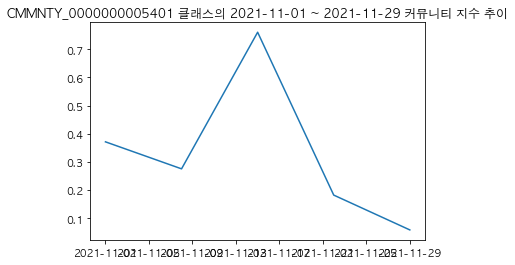

In [266]:
plt.title(f"{cmmnty_id} 클래스의 {min_date} ~ {max_date} 커뮤니티 지수 추이")
plt.plot(smpl_data['date'], smpl_data['comm_index'])

#### 학생별

In [384]:
## 특정 클래스 내 학생별 & 기간별 쿼리
query = {
  "size": 0,
  "query" : {
    "bool" : {
      "filter":[
    {"range" : {
      "post_frst_register_pnttm" : {
        "gte" : "2021-11-15T00:00:00.000Z",
        "lt" :"2021-12-01T00:00:00.000Z"
      }
    }},
    {"term" : {
      "cmmnty_id" : {
        "value" : "CMMNTY_0000000005401"
      }
     }}
    ]
   }
  },
  "aggs": {
    "comm_over_date" : {
      "date_histogram" : {
        "field" : "post_frst_register_pnttm",
        "calendar_interval" : "week"
      },
    "aggs": {
      "comm_per_student": {
        "terms": {
         "field": "post_frst_register_id.keyword"
        },
        
      "aggs": {
        "comment": {
          "value_count": {
            "field": "comment_frst_register_pnttm"
          }
        },
        "minmax_comments": {
          "normalize": {
            "buckets_path": "comment",          
            "method": "rescale_0_1",       
            "format": "00.00%"                
          }
        },
        "reply": {
          "value_count": {
            "field": "reply_frst_register_pnttm"
          }
        },
        "minmax_replies": {
          "normalize": {
            "buckets_path": "reply",          
            "method": "rescale_0_1",       
            "format": "00.00%"                
          }
        },
        "good": {
          "value_count": {
            "field": "good_frst_register_pnttm"
          }
        },
        "minmax_goods": {
          "normalize": {
            "buckets_path": "good",          
            "method": "rescale_0_1",       
            "format": "00.00%"                
          }
        },
        "comm_index": {
          "bucket_script" : {
            "buckets_path" : {
              "comment" : "minmax_comments",
              "reply" : "minmax_replies",
              "good" : "minmax_goods"
            },
            "script" : {
              "source" : "params.comment + params.reply + params.good"
            }
          }
        }
      }
    }
  }
 }
}
}





In [385]:
s = Search(using=es, index='toktok_op_talk*')
s.update_from_dict(query)
res = s.execute()
print(res.took)

40


In [329]:
result_list = []
for result in res.aggregations.comm_over_date.buckets:
    sub_result = result.comm_per_student.buckets
    for sub_res in sub_result:
        if len(sub_result) == 1:
            sub_res.comm_index = {'value' : 0}
        result_list.append((result.key_as_string, sub_res.key, sub_res.comm_index.value))

In [332]:
data = pd.DataFrame.from_records(result_list,columns=['date','student_post_id', 'comm_index'])
data['date'] = pd.to_datetime(data['date'])
data

,date,student_post_id,comm_index
0,2021-11-15 00:00:00+00:00,18-14anmyeong-p@gne.go.kr,2.333333
1,2021-11-15 00:00:00+00:00,18-2anmyeong-p@gne.go.kr,1.000000
2,2021-11-15 00:00:00+00:00,18-15anmyeong-p@gne.go.kr,0.333333
3,2021-11-15 00:00:00+00:00,18-9anmyeong-p@gne.go.kr,0.333333
4,2021-11-15 00:00:00+00:00,18-4anmyeong-p@gne.go.kr,0.000000
5,2021-11-22 00:00:00+00:00,18-14anmyeong-p@gne.go.kr,0.000000
6,2021-11-29 00:00:00+00:00,18-14anmyeong-p@gne.go.kr,0.000000


In [335]:
#student_id = data['student_post_id'].sample(1).values[0]
student_id = "18-14anmyeong-p@gne.go.kr"
smpl_data = data[data['student_post_id'] == student_id]
min_date = datetime.strftime(smpl_data['date'].min().date(), "%Y-%m-%d")
max_date = datetime.strftime(smpl_data['date'].max().date(), "%Y-%m-%d")
smpl_data

,date,student_post_id,comm_index
0,2021-11-15 00:00:00+00:00,18-14anmyeong-p@gne.go.kr,2.333333
5,2021-11-22 00:00:00+00:00,18-14anmyeong-p@gne.go.kr,0.000000
6,2021-11-29 00:00:00+00:00,18-14anmyeong-p@gne.go.kr,0.000000


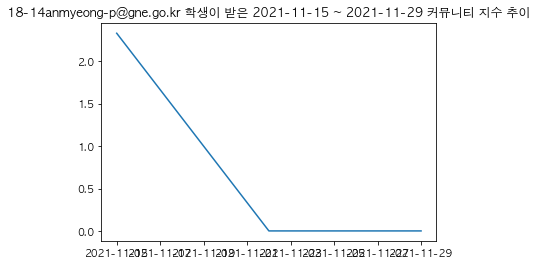

In [337]:
plt.title(f"{student_id} 학생이 받은 {min_date} ~ {max_date} 커뮤니티 지수 추이")
plt.plot(smpl_data['date'], smpl_data['comm_index'])

## 과제 제출 관련

### 현재(이번주) 학생에게 출제된 과제 수 대비 제출한 과제 수 
최근 일주일 내에 끝나는 과제 중 제출한 과제 수

In [676]:
# 현재 학생이 제출한 과제 수 
query = {"size": 0,
  "query" : {
    "bool" : {
      "filter":[
    {"range" : {
      "last_updusr_pnttm" : {
        "gte" : "2021-11-15T00:00:00.000Z",
        "lt" :"2021-12-01T00:00:00.000Z"
      }
    }},
    {"term" : {
      "cmmnty_id" : {
        "value" : "CMMNTY_0000000000869"
      }
     }},
     {"term" : {
       "last_updusr_id" : {
         "value": "bbqc8282@gne.go.kr"
       }
     }
       
     }
    ]
   }
  },
  "aggs" : {
    "submit_per_student" : {
      "terms" : {
        "field" : "last_updusr_id"
      }
    },
      "submit_count" : {
        "value_count": {
          "field": "ntt_no"
        
      }
    }
  }
}

In [677]:
s = Search(using=es, index='toktok_op_assignable_submit*')
s.update_from_dict(query)
res = s.execute()
print(res.took)

5


In [678]:
result = res.aggregations

In [679]:
student_id = result.submit_per_student.buckets[0].key
submit_count = result.submit_count.value
print(student_id, submit_count)

bbqc8282@gne.go.kr 2


In [388]:
# 현재 학생에게 출제된 과제 수
query = {"size": 0,
  "query" : {
    "bool" : {
      "filter":[
    {"range" : {
      "assignable_end_date" : {
        "gte" : "2021-11-15T00:00:00.000Z",
        "lt" :"2021-12-01T00:00:00.000Z"
      }
    }},
    {"term" : {
      "cmmnty_id.keyword" : {
        "value" : "CMMNTY_0000000000869"
      }
     }}
    ]
   }
  },
  "aggs" : {
    "assign_per_class" : {
      "terms" : {
        "field" : "cmmnty_id.keyword"
      }
    },
      "assign_count" : {
        "value_count": {
          "field": "ntt_no"
        
      }
    }
  }
}

In [389]:
s = Search(using=es, index='toktok_op_assignable_regist*')
s.update_from_dict(query)
res = s.execute()
print(res.took)

4


In [363]:
result = res.aggregations
class_id = result.assign_per_class.buckets[0].key
assign_count = result.assign_count.value
print(class_id, assign_count)

CMMNTY_0000000000869 3


In [437]:
print(submit_count/assign_count)

0.3333333333333333


### 현재 출제된 과제 리스트

In [380]:
query = {
  "query" : {
    "bool" :{
      "filter" : [
    {"term" : {
      "cmmnty_id.keyword" : {
        "value" : "CMMNTY_0000000000869"
      }
    }},
    {"range" : {
      "assignable_end_date" : {
        "gte" : "2021-11-15T00:00:00.000Z",
        "lt" :"2021-12-01T00:00:00.000Z"
      }
    }}
    ]
    }  
}
}

In [381]:
s = Search(using=es, index='toktok_op_assignable_regist*')
s.update_from_dict(query)
res = s.execute()
print(res.took)

4


In [382]:
result_list = []
for hit in res.hits:
    result_list.append((hit.cmmnty_id, hit.bbs_id, hit.ntt_no, hit.assignable_start_date, hit.assignable_end_date, hit.ntcr_nm, hit.ntt_sj))

In [383]:
data = pd.DataFrame.from_records(result_list,columns=['cmmnty_id', 'bbs_id', 'ntt_no', 'assignable_start_date', 'assignable_end_date', 'ntcr_nm', 'ntt_sj'])
data['assignable_start_date'] = pd.to_datetime(data['assignable_start_date'])
data['assignable_end_date'] = pd.to_datetime(data['assignable_end_date'])
data

,cmmnty_id,bbs_id,ntt_no,assignable_start_date,assignable_end_date,ntcr_nm,ntt_sj
0,CMMNTY_0000000000869,BBSMSTR_000000003957,256474,2021-11-29,2021-11-30,윤태영,11월 4주차 일일임무(기후천사단 부분) 정산
1,CMMNTY_0000000000869,BBSMSTR_000000003957,256469,2021-11-29,2021-11-30,윤태영,11월 4주차 일일임무 정산
2,CMMNTY_0000000000869,BBSMSTR_000000003957,258609,2021-11-28,2021-11-29,윤태영,토지조사사업 실시 안내
